# Часть А

### №1
Если, добавив константный признак, мы получили улучшение качества модели, то наша модель – линейная
Посчитаем MSE нынешней модели: (80 * 0.5^2 + 20 * 0.3^2) / 100 = 0.218

Добавив константный признак, мы поднимем (опустим) нашу прямую на C. 

Наша C должна быть такой, чтобы минимизировать MSE, а в нашем случае - сделать ошибку нулевой на большинстве объектов выборки. Таким образом, 

Ответ: **C существует и равен 0.5**

Новый MSE: (20 * -(0.8)^2) / 100 = 0.128

### №2

Случайный лес не сможет дать отрицательный предикшн, так как он усредняет значения базовых алгоритмов (отрицательным значениям запросто неоткуда взяться). 

Градиентный бустинг же при высоком lr и малом количестве итераций способен выдать отрицательный предикшн

Ответ: **Градиентный бустинг**

### №4

Для оптимального кода необходимо инициализировать переменные **n** (количество значений) и **s** (сумма квадратов значений) как нули.

n - наш знаменатель;
s - сумма квадратов отклонений от нуля

Код:


    stream = Stream(port=port, host=host)
    while stream.has_next():
        value = stream.next_value()
        n += 1
        s += value ** 2
        std_value = sqrt(s / n)
        print(std_value)

### №1
    SELECT task_id 
    FROM table 
    WHERE task_id > (SELECT COUNT(task_id) FROM table GROUP BY task_id)

# Часть B

Корректно работающий код:

In [1]:
# task.py
import time
class Task:
    def __init__(self, value):
        self.status = 'ready'
        self.value = value
    def execute(self):
        return self.value ** 2

# counter.py
import time    
class Counter:
    def __init__(self):
        self.value = 0
    def update(self, new_value):
        # если переменная local не является необходимой для работы кода, можно избежать ее создания и напрямую увеличивать self.value
        time.sleep(0.1)
        local = self.value
        local += new_value
        self.value = local
        
# main.py
from concurrent.futures import ThreadPoolExecutor
# from counter import Counter
# from task import Task

new_counter = Counter()
with ThreadPoolExecutor(max_workers=2) as executor:
    for _ in range(10):
        executor.submit(new_counter.update, Task(2).execute())
print(new_counter.value)

40


# Часть C

В дальнейшем EDA я выделил три основные классификации юзеров и три побочные.

Основные:

1. **Пол**
2. **Возраст** (выделил 5 кластеров: до 25 лет, 25-35 лет, 35-45 лет, 45-55 лет, больше 55 лет)
3. **Типы потребления** (чтение ленты, сообщения)

Побочные:

1. **Популярные юзеры**
2. **Спаммеры** (к сожалению, хоть и в описании задачи было сказано, что есть информация о количестве помещений пользователя в чёрные списки, в датасете этой переменной нет). Тем не менее, было бы интересно рассмотреть юзеров, которые часто находятся в черных списках других людей (выдвинуть гипотезу, что такие юзеры - мошенники и спамеры)

In [1]:
# Библиотеки и данные

import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import *
import scipy
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18, 'figure.figsize': (15,7)})

import random
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv(r'D:\task_for_a_prod_analytics_trainee_part_c.csv')

Создадим новые переменные и создадим необходимые функции

In [3]:
# Разбиение юзеров по возрастным группам
df['age_group'] = "0"
df.loc[(df['user_age'] < 25) & (df['user_age'] != 0), 'age_group'] = 'under_25'
df.loc[(df['user_age'] >= 25) & (df['user_age'] < 35), 'age_group'] = 'between_25_35'
df.loc[(df['user_age'] >= 35) & (df['user_age'] < 45), 'age_group'] = 'between_35_45'
df.loc[(df['user_age'] >= 45) & (df['user_age'] < 55), 'age_group'] = 'between_45_55'
df.loc[(df['user_age'] >= 55) & (df['user_age'] <= 100), 'age_group'] = 'over_55'


# Является ли использование ВКонтакте ежедневной процедурой
df['is_everyday_1week'] = 0
df.loc[df['days_in_vk_1_week'] == 7, 'is_everyday_1week'] = 1


# Пользователи, которые с большой вероятностью не будут использовать ВК в будущем (потребление постепенно снижается)
df['going_to_leave'] = 0
df.loc[(df['days_in_vk_1_week'] / 7 < 
       (df['days_in_vk_2_weeks'] - df['days_in_vk_1_week']) / 7) &  
      ((df['days_in_vk_2_weeks'] - df['days_in_vk_1_week']) / 7 > (df['days_in_vk_4_weeks'] - df['days_in_vk_2_weeks']) / 14), 'going_to_leave'] = 1


# Является ли ВК площадкой в основном для общения или же юзер больше интересуется чтением ленты
df['for_messages'] = 1
df.loc[df['timespent_feed'] < df['timespent_im'], 'for_messages'] = 0


df['is_male'] = 0
df.loc[df['user_sex'] == 'male', 'is_male'] = 1

# Генерация подвыборок для статистических тестов
def data_preparation(column, df):
    random.seed(1)
    base = df[column].value_counts()[0]

    indices = []
    for cluster in np.unique(df[column]):
        cur_cluster_amount = df[column].value_counts()[cluster]
        tmp = df[df[column] == cluster]
        sample = random.sample(list(tmp.index), int(100 * cur_cluster_amount / base))
        indices += sample
    subsample = df.loc[indices]
    
    return subsample

# доверительные интервалы и тест для пропорций, независимые выборки
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

# для сравнения более чем двух выборок на пропорции
def Marascuillo_procedure(group_col, main_col, df, alpha):
    group = pd.DataFrame(df.groupby(group_col)[main_col].mean())
    group['n'] = df.groupby(group_col)[main_col].count().values
    group.columns = ['p', 'n'] 

    chi_crit = np.sqrt(chi2.ppf(alpha, group.shape[0] - 1))
    for left in range(len(group.index) - 1):
        for right in range(left + 1, len(group.index)):
            p_diff = abs(group['p'][group.index[left]] - group['p'][group.index[right]])
            crit_point = chi_crit * np.sqrt((group['p'][group.index[left]]*(1 - group['p'][group.index[left]])
                                            )/group['n'][group.index[left]] + 
                                           (group['p'][group.index[right]]*(1 - group['p'][group.index[right]])
                                            )/group['n'][group.index[right]])
            if p_diff > crit_point:
                decision = 'reject'
            else:
                decision = 'not reject'
            print('{} and {}, decision: {}'.format(group.index[left], group.index[right], decision))

### Пол
Мужчина/женщина, "unknown" было дропнуто

Выводы:
1. Мужчин больше, чем женщин
2. У мужчин в среднем больше друзей, чем у женщин
3. У мужчин в среднем больше сообществ, чем у женщин
4. Хоть графики гласят, что мужчины more likely to have больше подписок, но эта разница не является значимой
5. График показывает, что мужчины с большей вероятностью заходят в ВК ежедневно в течение предыдущей недели, но этот вывод не является статистичесски значимым
6. Абсолютно так же, как и в пункте 5: несмотря на то, что график показывает более явную склонность мужчин к уходу из ВК, чем у женщин, но соответствующие статистические тесты не позволяют сделать такой вывод
7. Разница между женщинами и мужчинами в использовании мобильных устройств отсуствует.

In [4]:
gender = df[df['user_sex'] != 'unknown']
sex_subsample = data_preparation('user_sex', gender)

<AxesSubplot:xlabel='user_sex', ylabel='count'>

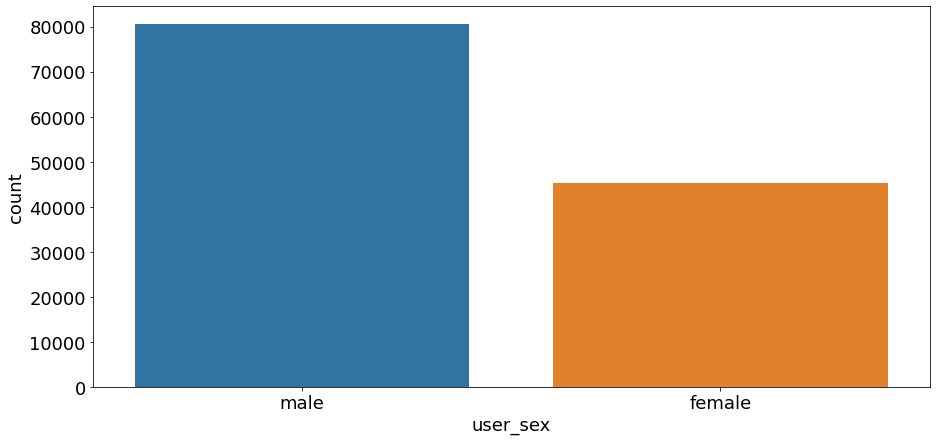

In [5]:
# Доли
sns.countplot(gender.user_sex)

In [6]:
# ДИВАЙСЫ

print(gender[gender['user_sex'] == 'male'].device_model.value_counts(normalize=True).head())
print('______________________')
print(gender[gender['user_sex'] == 'female'].device_model.value_counts(normalize=True).head())

iPhone 11           0.058576
iPhone 7            0.045406
iPhone XR           0.043951
iPhone SE (GSM)     0.023739
Redmi Note 8 Pro    0.021872
Name: device_model, dtype: float64
______________________
iPhone 11    0.086961
iPhone XR    0.045912
iPhone 7     0.045343
iPhone 8     0.026487
iPhone 6s    0.023021
Name: device_model, dtype: float64


270.82481571687777
152.46579241634123
Ttest_indResult(statistic=2.309856357432295, pvalue=0.022224408220261078)


<AxesSubplot:xlabel='user_sex', ylabel='user_friends'>

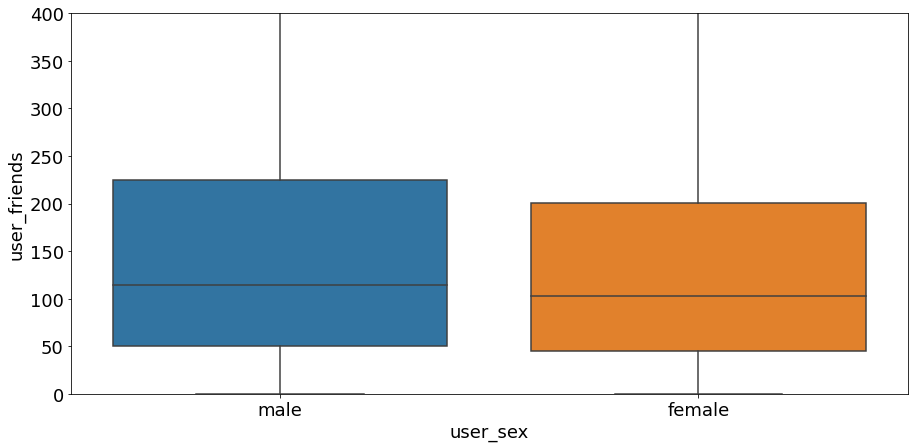

In [7]:
# КОЛ-ВО ДРУЗЕЙ
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].user_friends, ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].user_friends, ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].user_friends, 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].user_friends, equal_var = False))

# У мужчин больше

plt.ylim(0, 400)
sns.boxplot(data=gender, y='user_friends', x='user_sex')

237.9264583772885
196.6330016494239
Ttest_indResult(statistic=2.3163605543817276, pvalue=0.022071876882373748)


<AxesSubplot:xlabel='user_sex', ylabel='user_communities_count'>

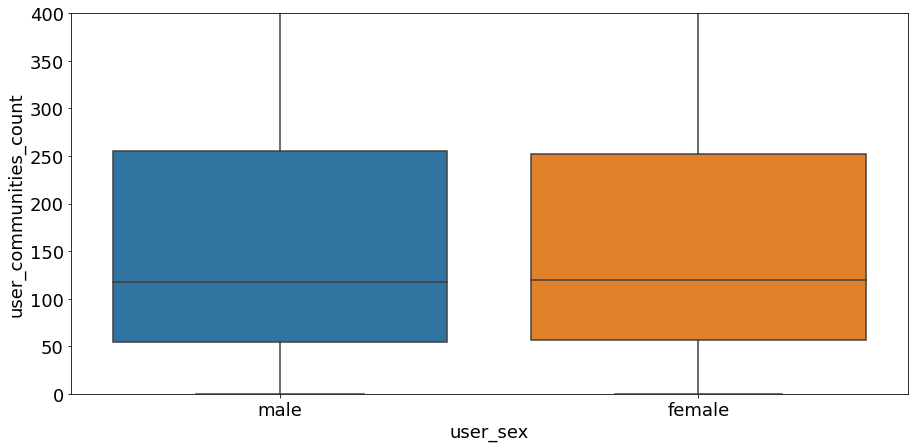

In [8]:
# СООБЩЕСТВА

print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].user_communities_count, ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].user_communities_count, ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].user_communities_count, 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].user_communities_count, equal_var = False))
# У мужчин больше

plt.ylim(0, 400)
sns.boxplot(data=gender, y='user_communities_count', x='user_sex')

174.1363598395861
488.3904641314626
Ttest_indResult(statistic=-0.6585032297529995, pvalue=0.5126168172870553)


<AxesSubplot:xlabel='user_sex', ylabel='user_fans_count'>

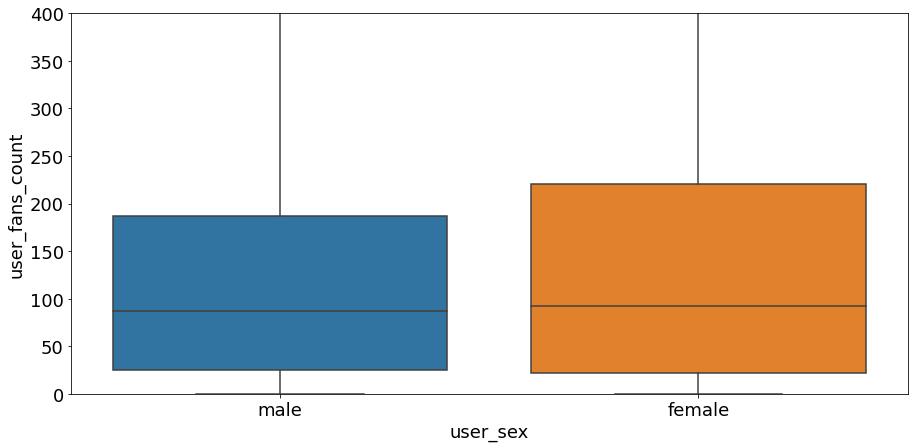

In [9]:
# КОЛ-ВО ПОДПИСЧИКОВ
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].user_fans_count , ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].user_fans_count , ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].user_fans_count, 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].user_fans_count, equal_var = False))

# не проходим по Беренцу-Фишеру (женщины имеют большее отклонение)

plt.ylim(0, 400)
sns.boxplot(data=gender, y='user_fans_count', x='user_sex')

65.79465683995068
43.43173476175669
Ttest_indResult(statistic=1.3628767652597722, pvalue=0.17496687143173328)


<AxesSubplot:xlabel='user_sex', ylabel='user_subscriptions_count'>

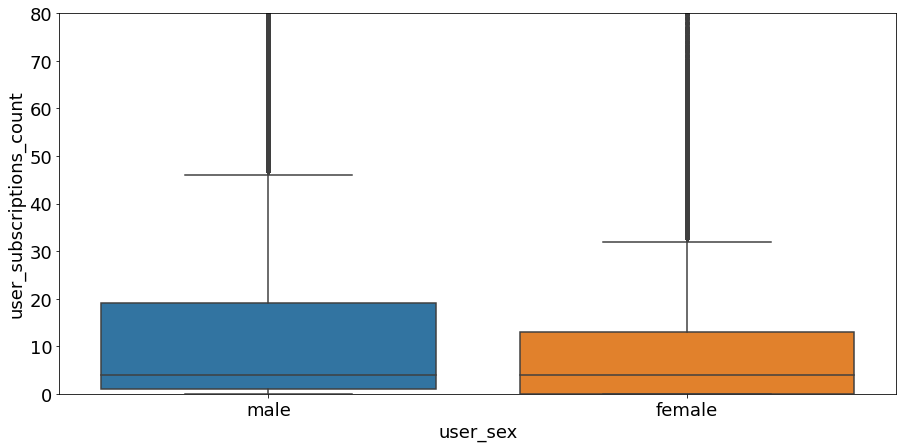

In [10]:
# КОЛ-ВО ПОДПИСОК

print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].user_subscriptions_count , ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].user_subscriptions_count , ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].user_subscriptions_count, 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].user_subscriptions_count, equal_var = False))

# различие не значимое

plt.ylim(0, 80)
sns.boxplot(data=gender, y='user_subscriptions_count', x='user_sex')

p-value: 0.657542
95% confidence interval for a difference between proportions: [-0.090416, 0.144701]


(0.0, 90000.0)

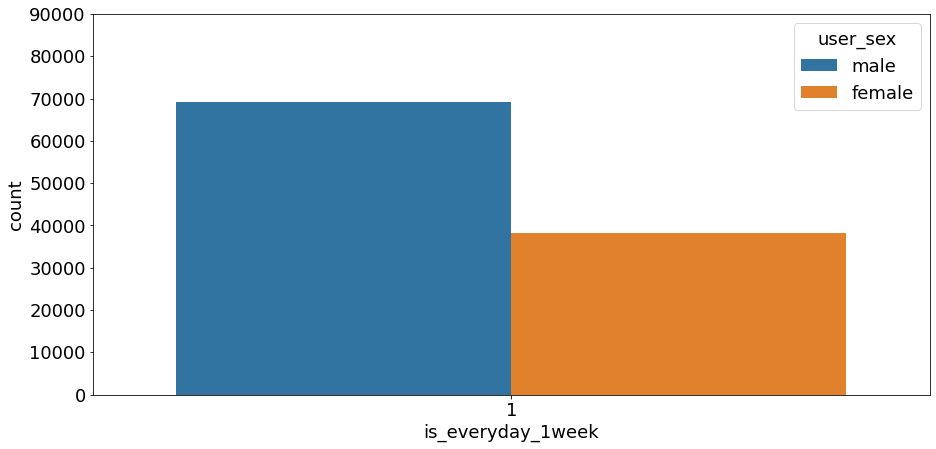

In [11]:
# ЕЖЕДНЕВНАЯ АКТИВНОСТЬ

    
print("p-value: %f" % proportions_diff_z_test(
    proportions_diff_z_stat_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].is_everyday_1week, 
                                 sex_subsample[sex_subsample['user_sex'] == 'female'].is_everyday_1week)))


print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(sex_subsample[sex_subsample['user_sex'] == 'female'].is_everyday_1week, 
                                 sex_subsample[sex_subsample['user_sex'] == 'male'].is_everyday_1week))

# различие не значимое

sns.countplot(data=gender[gender['is_everyday_1week'] == 1], x='is_everyday_1week', hue='user_sex')
plt.ylim(0, 90000)

p-value: 0.694488
95% confidence interval for a difference between proportions: [-0.056807, 0.083950]


<AxesSubplot:xlabel='going_to_leave', ylabel='count'>

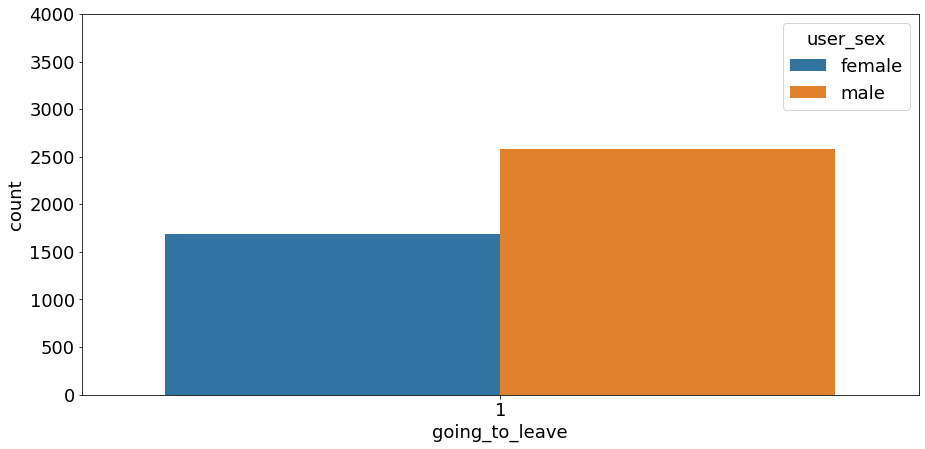

In [12]:
# СНИЖЕНИЕ ПОТРЕБЛЕНИЯ ВК

print("p-value: %f" % proportions_diff_z_test(
    proportions_diff_z_stat_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].going_to_leave, 
                                 sex_subsample[sex_subsample['user_sex'] == 'female'].going_to_leave)))

print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(sex_subsample[sex_subsample['user_sex'] == 'female'].going_to_leave, 
                                 sex_subsample[sex_subsample['user_sex'] == 'male'].going_to_leave))

# различие не значимое

plt.ylim(0, 4000)
sns.countplot(data=gender[gender['going_to_leave'] == 1], x='going_to_leave', hue='user_sex')

97.06527221775599
176.85340249490812
Ttest_indResult(statistic=-0.6890478262293096, pvalue=0.49294943261595336)


<AxesSubplot:xlabel='user_sex', ylabel='messaging_total'>

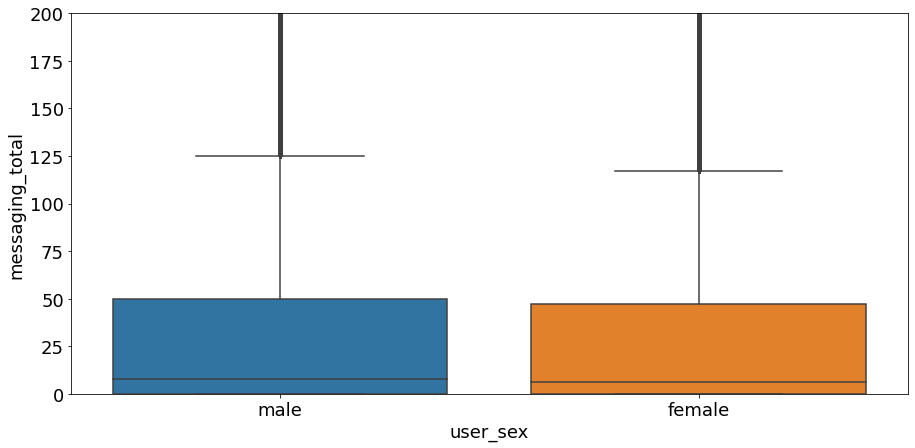

In [13]:
# КОЛ-ВО СООБЩЕНИЙ

print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].messaging_total , ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].messaging_total , ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].messaging_total, 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].messaging_total, equal_var = False))

# различие не значимое

plt.ylim(0, 200)
sns.boxplot(data=gender, y='messaging_total', x='user_sex')

4176.894828890975
3872.669849846368
Ttest_indResult(statistic=-0.5068491639168335, pvalue=0.6131801748285202)


<AxesSubplot:xlabel='user_sex', ylabel='timespent_total'>

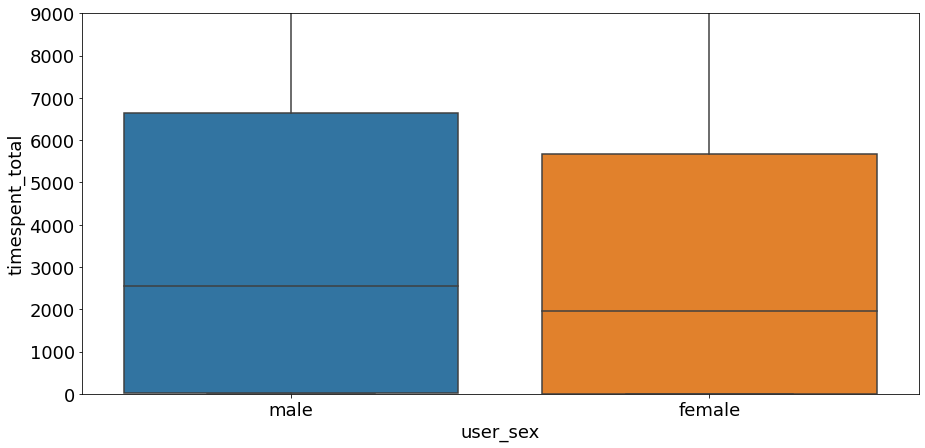

In [14]:
# ОБЩЕЕ ВРЕМЯ

print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].timespent_total  , ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].timespent_total  , ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].timespent_total , 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].timespent_total , equal_var = False))

# различие не значимое

plt.ylim(0, 9000)
sns.boxplot(data=gender, y='timespent_total', x='user_sex')

1180.019728434635
1770.5404630137182
Ttest_indResult(statistic=-1.5526604099285473, pvalue=0.12431312391152603)


<AxesSubplot:xlabel='user_sex', ylabel='timespent_feed'>

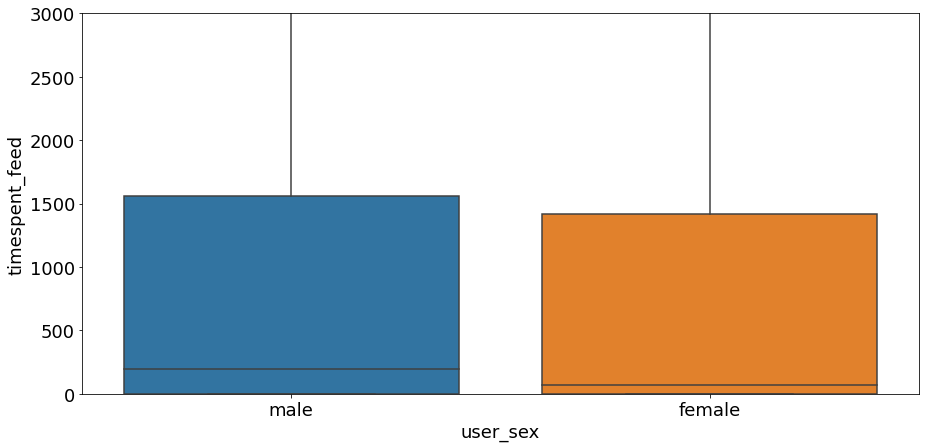

In [15]:
# ВРЕМЯ В ЛЕНТЕ

print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].timespent_feed   , ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].timespent_feed   , ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].timespent_feed, 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].timespent_feed, equal_var = False))

# не проходим по Беренцу-Фишеру

plt.ylim(0, 3000)
sns.boxplot(data=gender, y='timespent_feed', x='user_sex')

319.2991687930289
199.9372231021982
Ttest_indResult(statistic=0.25568288626722085, pvalue=0.7985413386272527)


<AxesSubplot:xlabel='user_sex', ylabel='timespent_photo'>

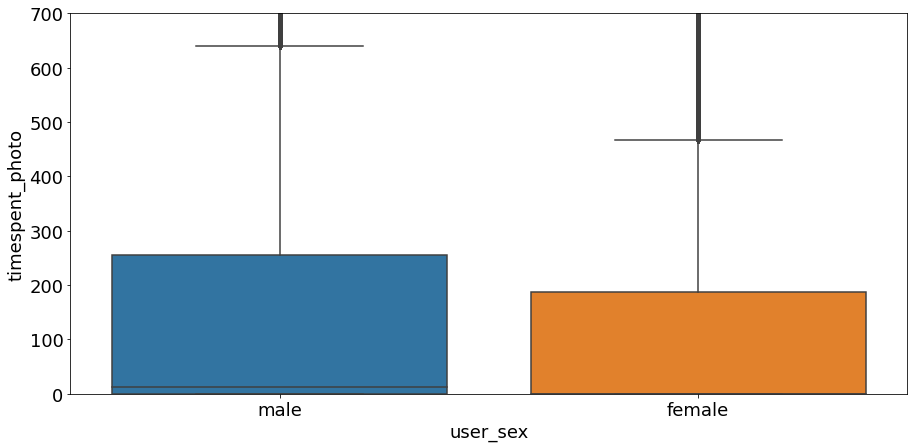

In [16]:
# ВРЕМЯ В ПРОСМОТРЕ ФОТОК

print(np.std(sex_subsample[sex_subsample['user_sex'] == 'male'].timespent_photo, ddof=1))
print(np.std(sex_subsample[sex_subsample['user_sex'] == 'female'].timespent_photo, ddof=1))

print(scipy.stats.ttest_ind(sex_subsample[sex_subsample['user_sex'] == 'male'].timespent_photo, 
                      sex_subsample[sex_subsample['user_sex'] == 'female'].timespent_photo, equal_var = False))

# различие не значимое

plt.ylim(0, 700)
sns.boxplot(data=gender, y='timespent_photo', x='user_sex')

### Возраст
Как сказал ранее, разбил на 5 подгрупп (до 25 лет, 25-35 лет, 35-45 лет, 45-55 лет, больше 55 лет)

Выводы:
1. В основном преобладают молодые люди (до 35 лет)
2. В возрастных кластерах до 25 лет и 25-35 лет преобладают мужчины
3. Люди в возрасте больше 55 лет тратят больше времени на просмотр ленты, чем люди до 35 лет
4. Люди до 25 лет тратят больше времени на просмотр ленты, чем 35-45-летние
5. 35-45-летние тратят больше времени на просмотр ленты, чем 25-35-летние
6. Хоть на граифке и показано, что люди до 25 лет отправляют больше сообщений, чем все остальные возрастные кластеры, статистические тесты не позволяют сделать такой вывод
7. У молодых юзеров (до 35 лет) новые и дорогие устройства являются крайне популярными. У более возрастной аудитории такая тенденция отсутствует.

In [17]:
age = df[(df.age_group != '0')]
age_subsample = data_preparation('age_group', age)

<AxesSubplot:xlabel='age_group', ylabel='count'>

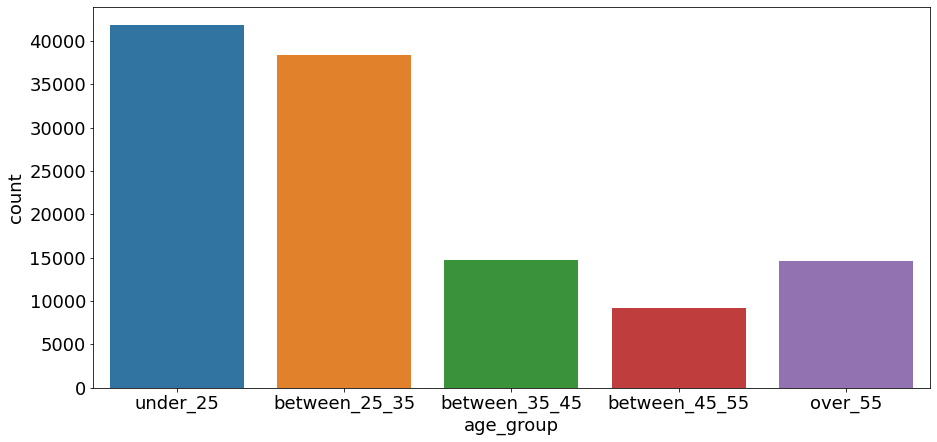

In [18]:
sns.countplot(data=age, x='age_group', 
              order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55'])

statistic: 6.45530407527216, p-value: 1.080018249213795e-10, cluster: between_25_35
statistic: 4.437059837324713, p-value: 9.119594909113534e-06, cluster: between_35_45
statistic: -1.6201851746019653, p-value: 0.1051925051200414, cluster: between_45_55
statistic: -0.6907915622357734, p-value: 0.489696538864409, cluster: over_55
statistic: 1.8298882785650499, p-value: 0.06726664653535186, cluster: under_25


<AxesSubplot:xlabel='age_group', ylabel='count'>

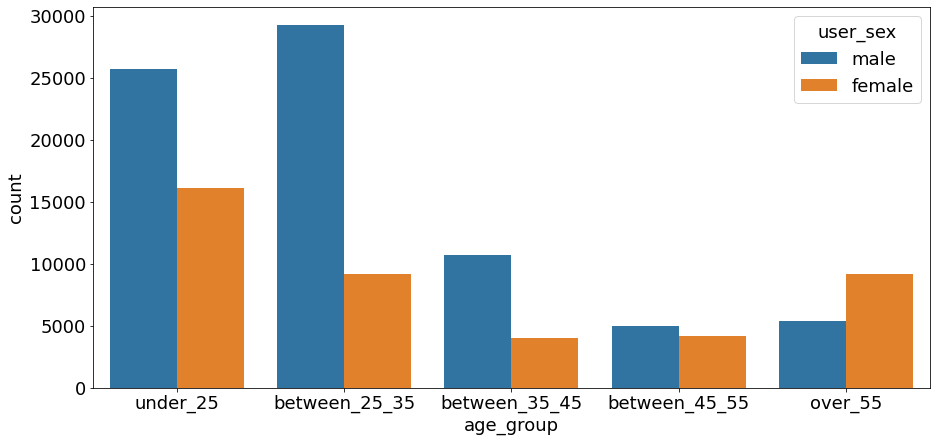

In [19]:
# ПОЛ

for cluster in np.unique(age_subsample.age_group):
    tmp = age_subsample[age_subsample['age_group'] == cluster]
    test = proportions_ztest(np.sum(tmp['is_male']), tmp.shape[0], 0.5)
    print('statistic: {}, p-value: {}, cluster: {}'.format(test[0], test[1], cluster))


sns.countplot(data=age[age['user_sex'] != 'unknown'], hue='user_sex', x='age_group', 
              order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55'])

In [20]:
for cluster in np.unique(age['age_group']):
    print(cluster)
    print('- - - - - - - - - ')
    print(age[age['age_group'] == cluster].device_model.value_counts(normalize=True).head())
    print('______________________')

between_25_35
- - - - - - - - - 
iPhone 11          0.079028
iPhone XR          0.049358
iPhone 7           0.046840
iPhone SE (GSM)    0.024057
iPhone 8           0.023724
Name: device_model, dtype: float64
______________________
between_35_45
- - - - - - - - - 
iPhone 7            0.023638
Redmi Note 8 Pro    0.023473
iPhone 11           0.018385
Redmi Note 7        0.017236
iPhone SE (GSM)     0.016497
Name: device_model, dtype: float64
______________________
between_45_55
- - - - - - - - - 
iPhone 7            0.023243
Redmi Note 7        0.020986
Redmi Note 8 Pro    0.019790
DUA-L22             0.015938
HRY-LX1             0.015407
Name: device_model, dtype: float64
______________________
over_55
- - - - - - - - - 
SM-A105F     0.020397
iPhone 7     0.020044
iPhone 6     0.019779
DUA-L22      0.019514
iPhone 6s    0.016600
Name: device_model, dtype: float64
______________________
under_25
- - - - - - - - - 
iPhone 11    0.105520
iPhone XR    0.066725
iPhone 7     0.062785
iPhone 8

         Multiple Comparison of Means - Tukey HSD, FWER=0.01          
    group1        group2     meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------
between_25_35 between_35_45 -175.8352 0.3571 -510.9101 159.2398  False
between_25_35 between_45_55 -157.8352 0.6386 -565.6754 250.0051  False
between_25_35       over_55 -251.7889 0.0737  -590.404  86.8261  False
between_25_35      under_25 -139.7866 0.2683 -383.8527 104.2795  False
between_35_45 between_45_55      18.0    0.9 -447.0094 483.0094  False
between_35_45       over_55  -75.9538    0.9  -481.614 329.7065  False
between_35_45      under_25   36.0486    0.9 -294.8114 366.9086  False
between_45_55       over_55  -93.9538    0.9 -561.5206  373.613  False
between_45_55      under_25   18.0486    0.9 -386.3359  422.433  False
      over_55      under_25  112.0024 0.7415 -222.4424 446.4471  False
----------------------------------------------------------------------
AxesSu

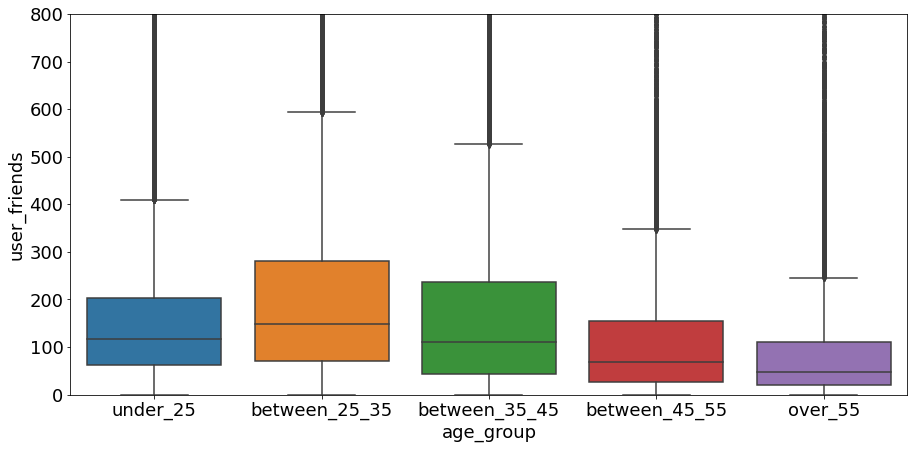

In [21]:
# КОЛ-ВО ДРУЗЕЙ

m_comp = pairwise_tukeyhsd(endog=age_subsample['user_friends'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

# различие не значимое
plt.ylim(0, 800)
plt.rcParams.update({'font.size': 18, 'figure.figsize': (15,7)})
print(sns.boxplot(data=age, y='user_friends', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))

         Multiple Comparison of Means - Tukey HSD, FWER=0.01          
    group1        group2     meandiff p-adj    lower    upper   reject
----------------------------------------------------------------------
between_25_35 between_35_45   57.1516 0.8221 -137.1757  251.479  False
between_25_35 between_45_55   -7.8864    0.9 -244.4142 228.6413  False
between_25_35       over_55  -92.0055  0.476  -288.386  104.375  False
between_25_35      under_25  -74.7855 0.3499 -216.3321  66.7611  False
between_35_45 between_45_55  -65.0381    0.9 -334.7212  204.645  False
between_35_45       over_55 -149.1571 0.1771 -384.4206  86.1063  False
between_35_45      under_25 -131.9371  0.118 -323.8201  59.9458  False
between_45_55       over_55   -84.119 0.7903 -355.2853 187.0472  False
between_45_55      under_25   -66.899 0.8395 -301.4226 167.6245  False
      over_55      under_25     17.22    0.9 -176.7419 211.1819  False
----------------------------------------------------------------------
AxesSu

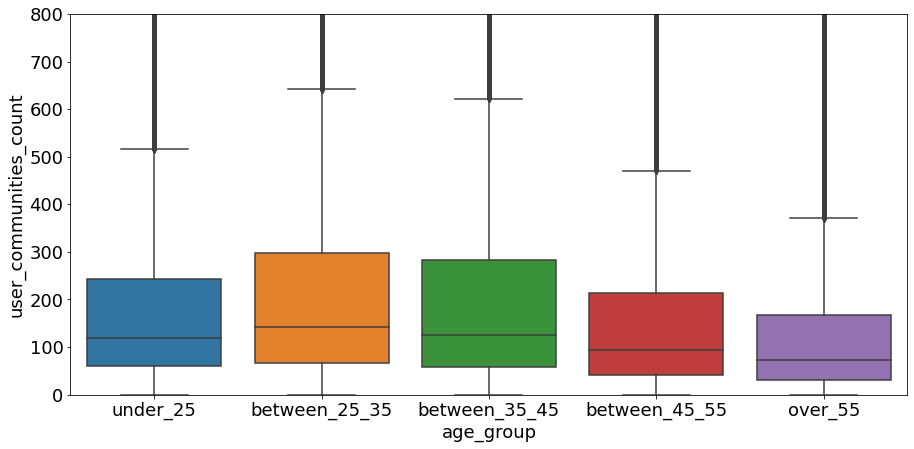

In [22]:
# СООБЩЕСТВА
m_comp = pairwise_tukeyhsd(endog=age_subsample['user_communities_count'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

# различие не значимое

plt.ylim(0, 800)
print(sns.boxplot(data=age, y='user_communities_count', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))

          Multiple Comparison of Means - Tukey HSD, FWER=0.01           
    group1        group2     meandiff p-adj    lower      upper   reject
------------------------------------------------------------------------
between_25_35 between_35_45  -75.0132    0.9 -1155.0355 1005.0091  False
between_25_35 between_45_55 -107.1465    0.9 -1421.7078 1207.4148  False
between_25_35       over_55 -123.2712    0.9  -1214.704  968.1617  False
between_25_35      under_25  252.7982 0.7683  -533.8818 1039.4783  False
between_35_45 between_45_55  -32.1333    0.9 -1530.9638 1466.6971  False
between_35_45       over_55   -48.258    0.9 -1355.7927 1259.2767  False
between_35_45      under_25  327.8114 0.7958  -738.6251  1394.248  False
between_45_55       over_55  -16.1246    0.9 -1523.1981 1490.9488  False
between_45_55      under_25  359.9448 0.8575  -943.4777 1663.3672  False
      over_55      under_25  376.0694 0.7139  -701.9215 1454.0603  False
---------------------------------------------------

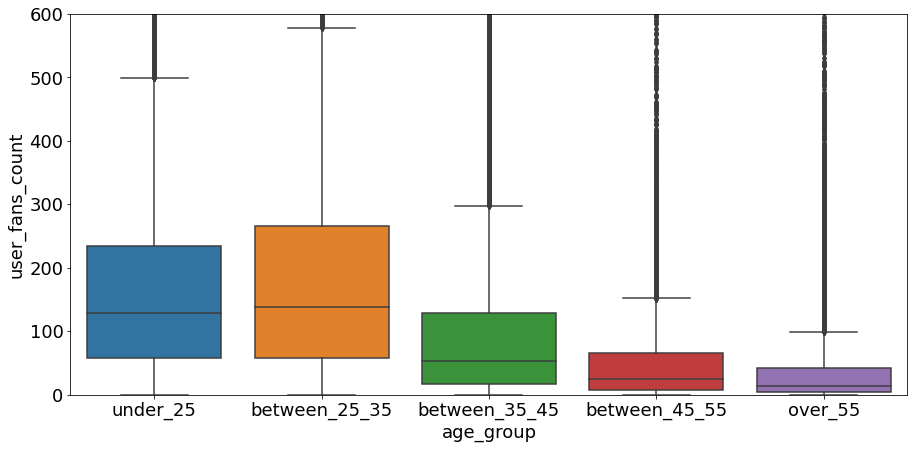

In [23]:
# ПОДПИСЧИКИ

m_comp = pairwise_tukeyhsd(endog=age_subsample['user_fans_count'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

# различие не значимое

plt.ylim(0, 600)
print(sns.boxplot(data=age, y='user_fans_count', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))


        Multiple Comparison of Means - Tukey HSD, FWER=0.01        
    group1        group2    meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
between_25_35 between_35_45  -9.8484    0.9 -58.7994 39.1027  False
between_25_35 between_45_55   7.0659    0.9 -52.5154 66.6473  False
between_25_35       over_55 -22.6778 0.4974  -72.146 26.7905  False
between_25_35      under_25 -13.4884 0.6558  -49.144 22.1673  False
between_35_45 between_45_55  16.9143    0.9 -51.0189 84.8475  False
between_35_45       over_55 -12.8294    0.9 -72.0923 46.4335  False
between_35_45      under_25    -3.64    0.9 -51.9753 44.6953  False
between_45_55       over_55 -29.7437 0.5429 -98.0505 38.5631  False
between_45_55      under_25 -20.5543 0.7158 -79.6308 38.5222  False
      over_55      under_25   9.1894    0.9 -39.6696 58.0484  False
-------------------------------------------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)


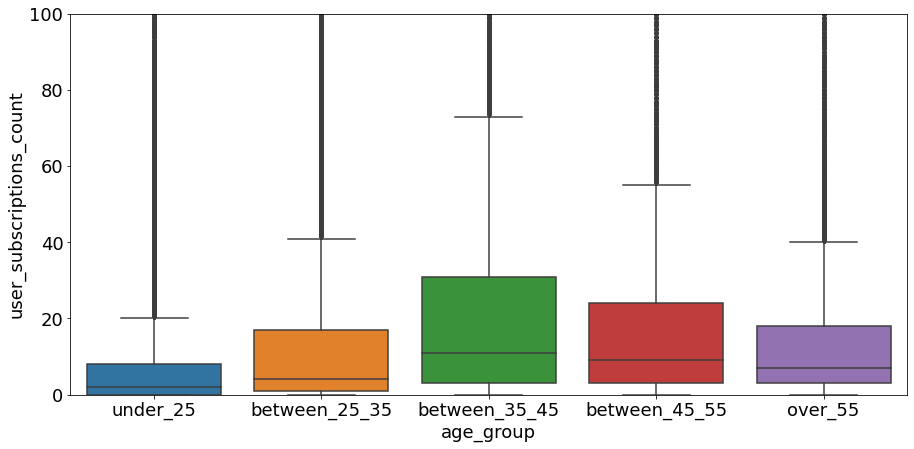

In [24]:
# ПОДПИСКИ

m_comp = pairwise_tukeyhsd(endog=age_subsample['user_subscriptions_count'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

# различие не значимое

plt.ylim(0, 100)
print(sns.boxplot(data=age, y='user_subscriptions_count', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))

between_25_35 and between_35_45, decision: not reject
between_25_35 and between_45_55, decision: not reject
between_25_35 and over_55, decision: not reject
between_25_35 and under_25, decision: not reject
between_35_45 and between_45_55, decision: not reject
between_35_45 and over_55, decision: not reject
between_35_45 and under_25, decision: not reject
between_45_55 and over_55, decision: not reject
between_45_55 and under_25, decision: not reject
over_55 and under_25, decision: not reject


<AxesSubplot:xlabel='is_everyday_1week', ylabel='count'>

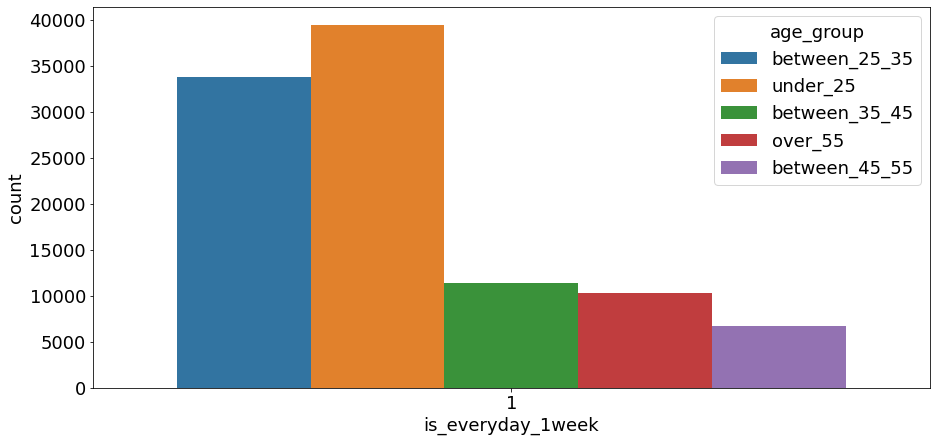

In [25]:
# ЕЖЕДНЕВНАЯ АКТИВНОСТЬ

Marascuillo_procedure('age_group', 'is_everyday_1week', age_subsample, 0.995)

# различие не значимое

sns.countplot(data=age[age['is_everyday_1week'] == 1], x='is_everyday_1week', hue='age_group')

between_25_35 and between_35_45, decision: not reject
between_25_35 and between_45_55, decision: not reject
between_25_35 and over_55, decision: not reject
between_25_35 and under_25, decision: not reject
between_35_45 and between_45_55, decision: not reject
between_35_45 and over_55, decision: not reject
between_35_45 and under_25, decision: not reject
between_45_55 and over_55, decision: not reject
between_45_55 and under_25, decision: not reject
over_55 and under_25, decision: not reject


<AxesSubplot:xlabel='going_to_leave', ylabel='count'>

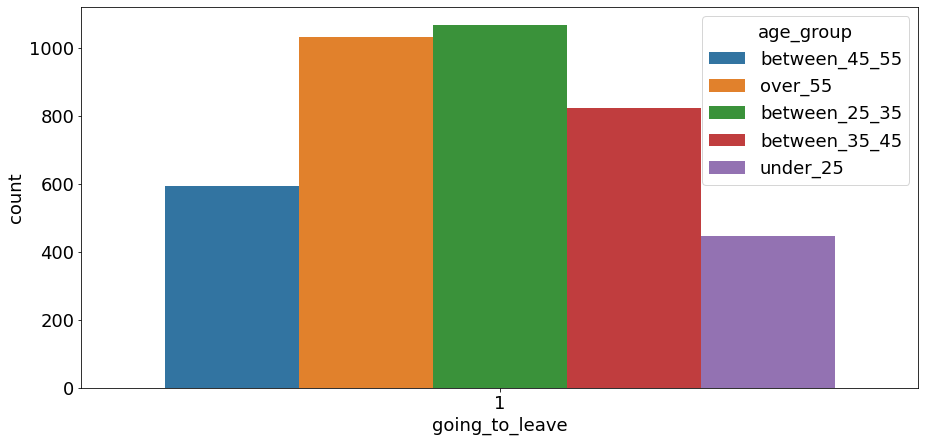

In [26]:
# СНИЖЕНИЕ ПОТРЕБЛЕНИЯ ВК

Marascuillo_procedure('age_group', 'going_to_leave', age_subsample, 0.995)

# различие не значимое

sns.countplot(data=age[age['going_to_leave'] == 1], x='going_to_leave', hue='age_group')

         Multiple Comparison of Means - Tukey HSD, FWER=0.01         
    group1        group2    meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------
between_25_35 between_35_45 -28.0176  0.723 -109.3971  53.3619  False
between_25_35 between_45_55 -32.9414 0.7461 -131.9934  66.1106  False
between_25_35       over_55 -19.8756    0.9 -102.1149  62.3637  False
between_25_35      under_25  49.0138 0.0337  -10.2624 108.2901  False
between_35_45 between_45_55  -4.9238    0.9 -117.8605 108.0128  False
between_35_45       over_55    8.142    0.9  -90.3805 106.6646  False
between_35_45      under_25  77.0314 0.0082   -3.3244 157.3873  False
between_45_55       over_55  13.0658    0.9 -100.4919 126.6236  False
between_45_55      under_25  81.9552 0.0312  -16.2575 180.1679  False
      over_55      under_25  68.8894 0.0272   -12.337 150.1159  False
---------------------------------------------------------------------
AxesSubplot(0.125,0.

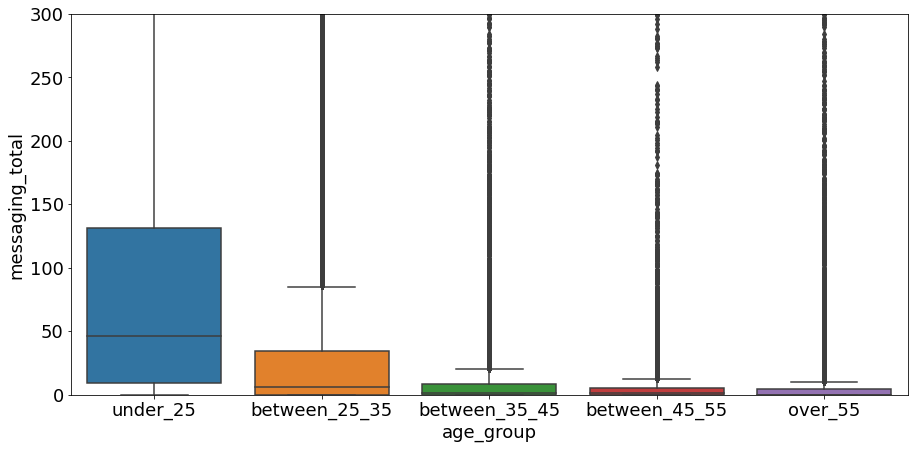

In [27]:
# КОЛ-ВО СООБЩЕНИЙ

m_comp = pairwise_tukeyhsd(endog=age_subsample['messaging_total'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

# различие не значимое

plt.ylim(0, 300)
print(sns.boxplot(data=age, y='messaging_total', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))

           Multiple Comparison of Means - Tukey HSD, FWER=0.01           
    group1        group2     meandiff  p-adj    lower      upper   reject
-------------------------------------------------------------------------
between_25_35 between_35_45  3338.6088 0.0203   -471.226 7148.4436  False
between_25_35 between_45_55   104.1136    0.9 -4533.0697 4741.2968  False
between_25_35       over_55  3651.0365 0.0092  -199.0496 7501.1226  False
between_25_35      under_25   369.8859    0.9 -2405.1689 3144.9408  False
between_35_45 between_45_55 -3234.4952 0.2074 -8521.6976 2052.7071  False
between_35_45       over_55   312.4277    0.9  -4299.969 4924.8244  False
between_35_45      under_25 -2968.7229 0.0485 -6730.6333  793.1876  False
between_45_55       over_55   3546.923 0.1381 -1769.3568 8863.2027  False
between_45_55      under_25   265.7724    0.9 -4332.1181 4863.6629  False
      over_55      under_25 -3281.1506 0.0234 -7083.8196  521.5185  False
--------------------------------------

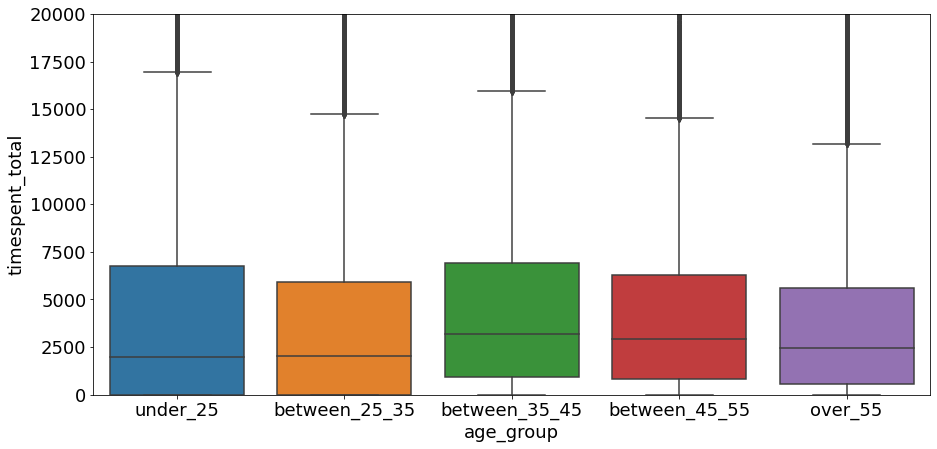

In [28]:
# ОБЩЕЕ ВРЕМЯ

m_comp = pairwise_tukeyhsd(endog=age_subsample['timespent_total'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

# различие не значимое

plt.ylim(0, 20000)
print(sns.boxplot(data=age, y='timespent_total', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))

           Multiple Comparison of Means - Tukey HSD, FWER=0.01           
    group1        group2     meandiff  p-adj    lower      upper   reject
-------------------------------------------------------------------------
between_25_35 between_35_45  1511.4044  0.001   177.1082 2845.7006   True
between_25_35 between_45_55  1042.8425 0.1672  -581.2111 2666.8961  False
between_25_35       over_55  1850.4657  0.001   502.0726 3198.8589   True
between_25_35      under_25  -146.0813    0.9 -1117.9726  825.8099  False
between_35_45 between_45_55  -468.5619    0.9 -2320.2679 1383.1441  False
between_35_45       over_55   339.0613    0.9 -1276.3114 1954.4341  False
between_35_45      under_25 -1657.4857  0.001 -2974.9976 -339.9738   True
between_45_55       over_55   807.6232 0.5462 -1054.2663 2669.5128  False
between_45_55      under_25 -1188.9238 0.0772 -2799.2161  421.3685  False
      over_55      under_25 -1996.5471  0.001 -3328.3336 -664.7605   True
--------------------------------------

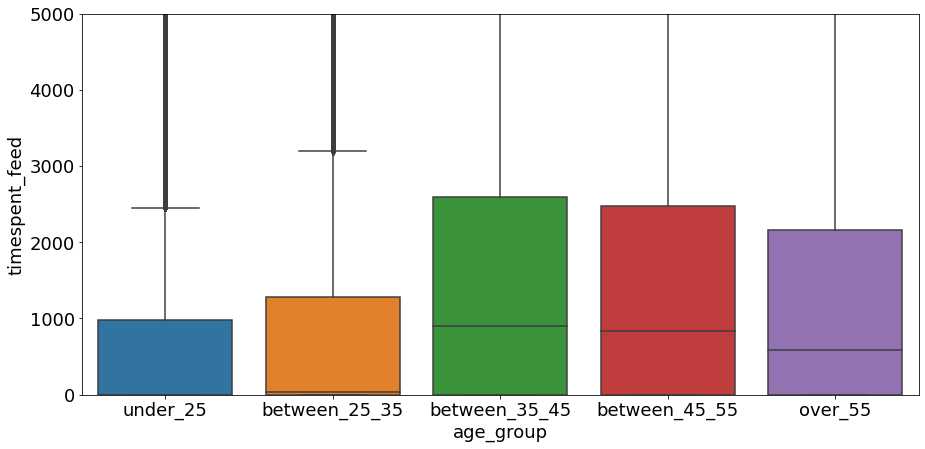

In [29]:
# ВРЕМЯ В ЛЕНТЕ

m_comp = pairwise_tukeyhsd(endog=age_subsample['timespent_feed'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

plt.ylim(0, 5000)
print(sns.boxplot(data=age, y='timespent_feed', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))

         Multiple Comparison of Means - Tukey HSD, FWER=0.01         
    group1        group2    meandiff p-adj    lower    upper   reject
---------------------------------------------------------------------
between_25_35 between_35_45  15.1736    0.9 -251.3777  281.725  False
between_25_35 between_45_55  25.2308    0.9 -299.2052 349.6668  False
between_25_35       over_55  99.6299 0.6724 -169.7376 368.9974  False
between_25_35      under_25   5.6693    0.9 -188.4847 199.8233  False
between_35_45 between_45_55  10.0571    0.9 -359.8568 379.9711  False
between_35_45       over_55  84.4563  0.886 -238.2455 407.1581  False
between_35_45      under_25  -9.5043    0.9 -272.7027 253.6941  False
between_45_55       over_55  74.3992    0.9 -297.5492 446.3475  False
between_45_55      under_25 -19.5614    0.9 -341.2483 302.1255  False
      over_55      under_25 -93.9606 0.7054 -360.0106 172.0894  False
---------------------------------------------------------------------
AxesSubplot(0.125,0.

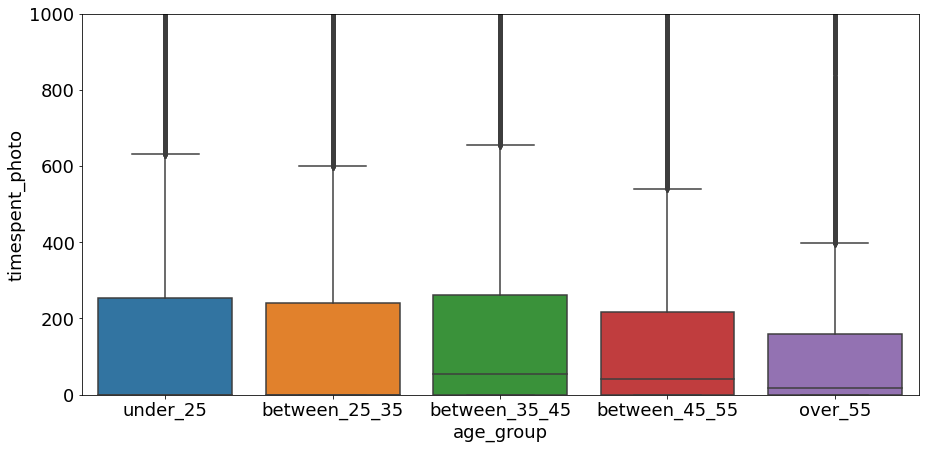

In [30]:
# ВРЕМЯ В ПРОСМОТРЕ ФОТОК

m_comp = pairwise_tukeyhsd(endog=age_subsample['timespent_photo'], groups=age_subsample['age_group'], alpha=0.005)
print(m_comp)

# различие не значимое

plt.ylim(0, 1000)
print(sns.boxplot(data=age, y='timespent_photo', x='age_group', 
                  order=['under_25', 'between_25_35', 'between_35_45', 'between_45_55', 'over_55']))

## Цель визита
На основе датасета вывел две основные причины использования ВК: общение и чтение ленты. Разбил юзеров в зависимости от их цели визита ВК.

Выводы по этой классификации:
1. Мужчины и женщины в равных пропорциях 
2. Схожий возраст
3. Юзеры, использующие ВК для общения, чаще имеют новые дорогие смартфоны, чем юзеры, в основном читающие ленту
4. Юзеры, использующие ВК для чтения ленты, с большей вероятностью использую ВК ежедневно, чем предпочитающие общение

In [31]:
aim_subsample = data_preparation('for_messages', df)

p-value: 0.433742
95% confidence interval for a difference between proportions: [-0.141942, 0.059873]


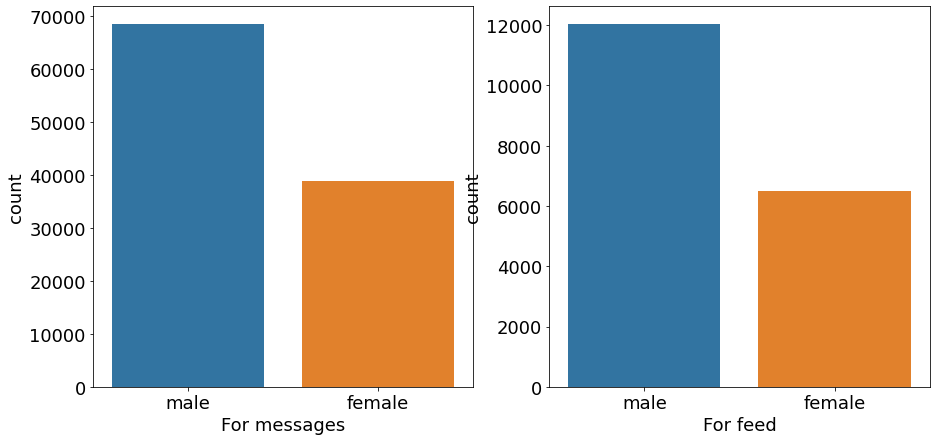

In [32]:
# ПОЛ

plt.subplot(1, 2, 1)
sns.countplot(data=df[(df['user_sex'] != 'unknown') & (df['for_messages'] == 1)], 
              x='user_sex')
plt.xlabel('For messages')

plt.subplot(1, 2, 2)
sns.countplot(data=df[(df['user_sex'] != 'unknown') & (df['for_messages'] == 0)], 
              x='user_sex')
plt.xlabel('For feed')


print("p-value: %f" % proportions_diff_z_test(
    proportions_diff_z_stat_ind(aim_subsample[aim_subsample['for_messages'] == 1].is_male, 
                                 aim_subsample[aim_subsample['for_messages'] == 0].is_male)))

print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(aim_subsample[aim_subsample['for_messages'] == 1].is_male, 
                                 aim_subsample[aim_subsample['for_messages'] == 0].is_male))

576.9195412363234
534.5797598076077
Ttest_indResult(statistic=-0.8905836227070166, pvalue=0.37466141400897557)


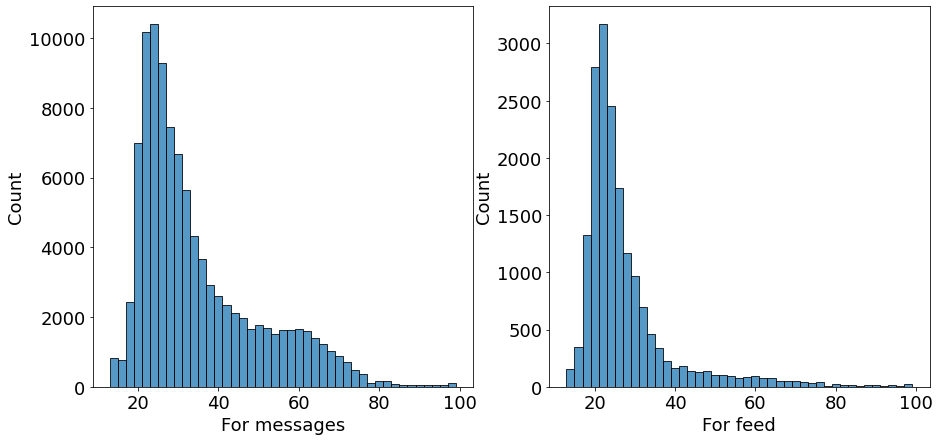

In [33]:
# ВОЗРАСТ

plt.subplot(1, 2, 1)
plt.xlabel('For messages')
sns.histplot(data=df[(df['for_messages'] == 1) & 
                     (df['user_age'] < 100) & 
                     (df['user_age'] != 0)], x='user_age', binwidth=2)

plt.subplot(1, 2, 2)
plt.xlabel('For feed')
sns.histplot(data=df[(df['for_messages'] == 0) & 
                     (df['user_age'] < 100) & 
                     (df['user_age'] != 0)], x='user_age', binwidth=2)


print(np.std(aim_subsample[aim_subsample['for_messages'] == 1].user_friends, ddof=1))
print(np.std(aim_subsample[aim_subsample['for_messages'] == 0].user_friends, ddof=1))

print(scipy.stats.ttest_ind(aim_subsample[aim_subsample['for_messages'] == 1].user_friends, 
                      aim_subsample[aim_subsample['for_messages'] == 0].user_friends, equal_var = False))

In [34]:
# ДИВАЙСЫ

print(df[df['for_messages'] == 1].device_model.value_counts(normalize=True).head())
print('___________________')
print(df[df['for_messages'] == 0].device_model.value_counts(normalize=True).head())

iPhone 11    0.082244
iPhone 7     0.054099
iPhone XR    0.053335
iPhone 8     0.027415
iPhone 6s    0.026156
Name: device_model, dtype: float64
___________________
Redmi Note 8 Pro    0.040518
Redmi Note 7        0.033136
SM-A515F            0.029529
SM-A505FN           0.023274
Redmi Note 9 Pro    0.018484
Name: device_model, dtype: float64


p-value: 0.000487
95% confidence interval for a difference between proportions: [-0.176983, -0.087154]


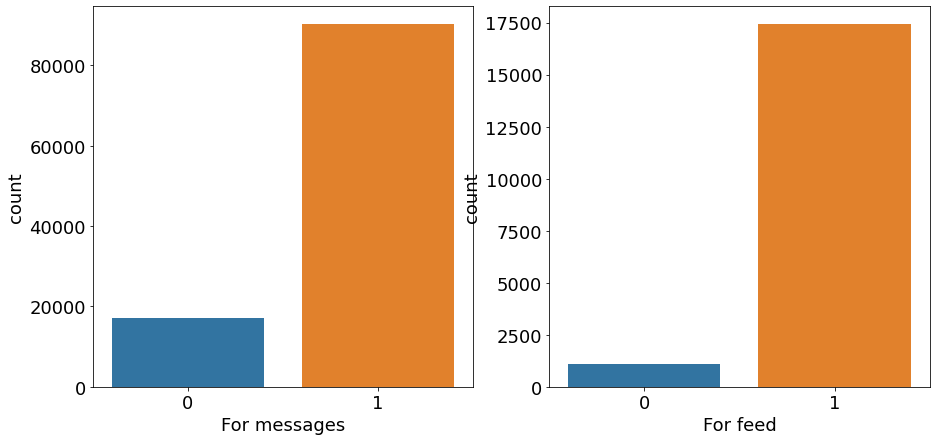

In [35]:
plt.subplot(1, 2,  1)
sns.countplot(data=df[(df['user_sex'] != 'unknown') & (df['for_messages'] == 1)], 
              x='is_everyday_1week')
plt.xlabel('For messages')

plt.subplot(1, 2, 2)
sns.countplot(data=df[(df['user_sex'] != 'unknown') & (df['for_messages'] == 0)], 
              x='is_everyday_1week')
plt.xlabel('For feed')



print("p-value: %f" % proportions_diff_z_test(
    proportions_diff_z_stat_ind(aim_subsample[aim_subsample['for_messages'] == 1].is_everyday_1week, 
                                 aim_subsample[aim_subsample['for_messages'] == 0].is_everyday_1week)))

print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(aim_subsample[aim_subsample['for_messages'] == 1].is_everyday_1week, 
                                 aim_subsample[aim_subsample['for_messages'] == 0].is_everyday_1week))

p-value: 0.596024
95% confidence interval for a difference between proportions: [-0.014952, 0.029434]


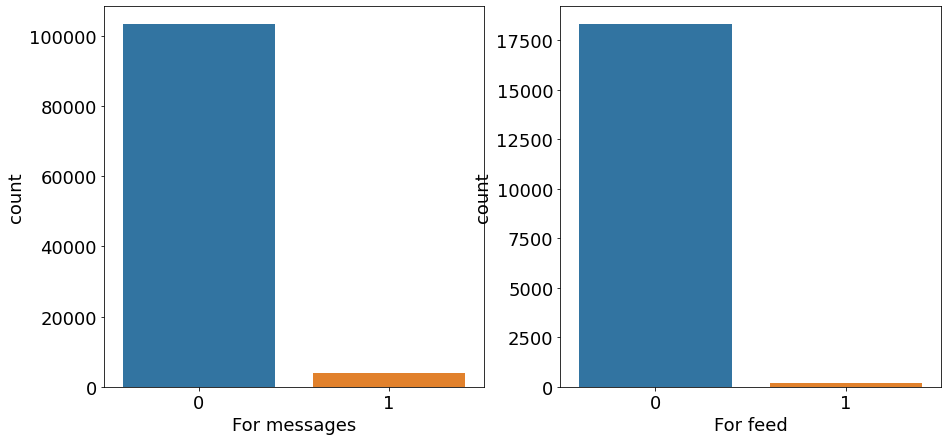

In [36]:
plt.subplot(1, 2, 1)
sns.countplot(data=df[(df['user_sex'] != 'unknown') & (df['for_messages'] == 1)], 
              x='going_to_leave')
plt.xlabel('For messages')

plt.subplot(1, 2, 2)
sns.countplot(data=df[(df['user_sex'] != 'unknown') & (df['for_messages'] == 0)], 
              x='going_to_leave')
plt.xlabel('For feed')

print("p-value: %f" % proportions_diff_z_test(
    proportions_diff_z_stat_ind(aim_subsample[aim_subsample['for_messages'] == 1].going_to_leave, 
                                 aim_subsample[aim_subsample['for_messages'] == 0].going_to_leave)))

print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(aim_subsample[aim_subsample['for_messages'] == 1].going_to_leave, 
                                 aim_subsample[aim_subsample['for_messages'] == 0].going_to_leave))

### Популярные аккаунты
Считаем аккаунт популярным, если у него больше подписчиков, чем друзей (предположим, на почти 2000 тысячи)

Опишем основные характеристики такого аккаунта
1. В основном, мужчины
2. Возраст совпадает с типичным по всем юзерам
3. Большое количество подписчиков
4. Имеют последние версии дорогих смартфонов
5. Пользуются ВК часто (возможно, ВК является площадкой для заработка)
6. Не снижают потребление ВК со временем

In [37]:
popular = df[df['user_friends'] - df['user_fans_count'] < np.quantile(df.user_friends - df.user_fans_count, 0.005)]

<AxesSubplot:xlabel='user_sex', ylabel='count'>

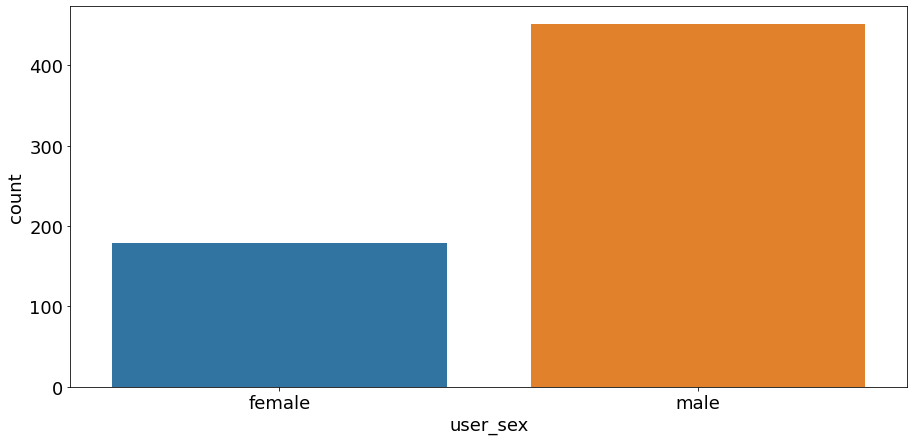

In [38]:
# ПОЛ

sns.countplot(popular.user_sex)

<AxesSubplot:xlabel='user_age', ylabel='Count'>

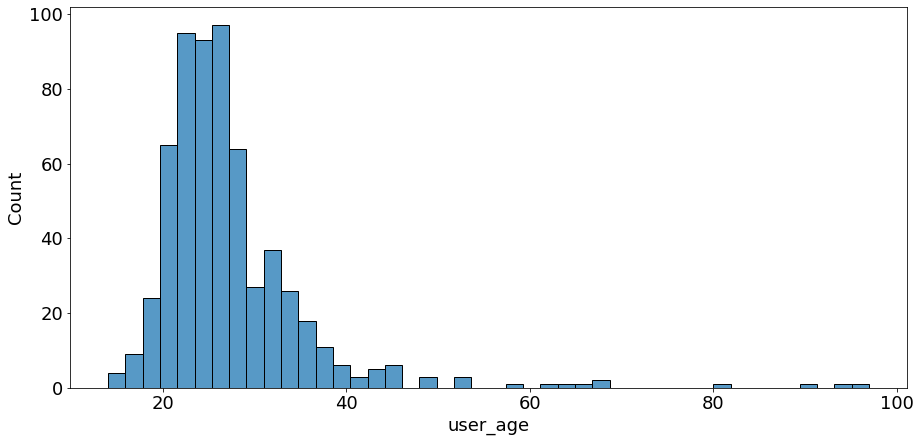

In [39]:
# ВОЗРАСТ

sns.histplot(popular[(popular['user_age'] < 100) & (popular['user_age'] != 0)].user_age)

<AxesSubplot:xlabel='user_fans_count', ylabel='Count'>

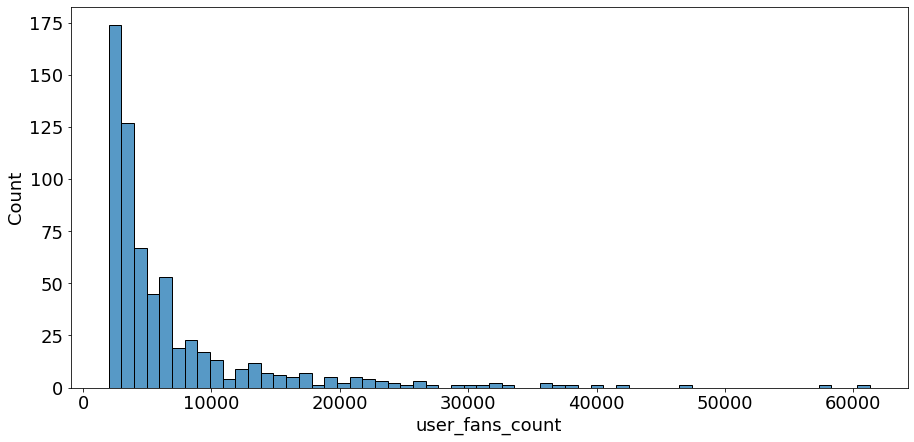

In [40]:
# ПОДПИСЧИКИ

sns.histplot(popular.user_fans_count)

In [41]:
# ДИВАЙСЫ

popular.device_model.value_counts(normalize=True).head()

iPhone 11        0.086331
iPhone XR        0.057554
iPhone 7         0.052158
iPhone X GSM     0.032374
iPhone 8 Plus    0.028777
Name: device_model, dtype: float64

In [42]:
# ЕЖЕДНЕВНАЯ АКТИВНОСТЬ

popular.is_everyday_1week.value_counts(normalize=True)

1    0.934921
0    0.065079
Name: is_everyday_1week, dtype: float64

In [43]:
# СНИЖЕНИЕ ПОТРЕБЛЕНИЯ ВК

popular.going_to_leave.value_counts(normalize=True)

0    0.987302
1    0.012698
Name: going_to_leave, dtype: float64

#### P.S
Честно говоря, очень понравился формат тестового задания, делал в свое удовольствие

Надеюсь, что смогу пройти отбор. Я люблю аналитику, а ВКонтакте - прекрасный работодатель. Горю желанием получить мэтч, который выльется во что-то взаимно полезное